In [64]:
import pandas as pd
pd.options.display.max_colwidth = 4000
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pickle
import seaborn as sns
import random
import itertools
import re
from collections import Counter
from wordcloud import WordCloud
import scipy.stats as stats
from scipy.stats import norm

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.layers import Embedding, Reshape, GlobalMaxPooling1D, Bidirectional, Dropout, Lambda
from tensorflow.keras.layers import LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Multiply
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LambdaCallback

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chufeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chufeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/chufeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chufeng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [66]:
# Preprocessing
def basic_processing(df):
    words_to_remove = ["e.g.", "code", "may", "attack", "system", "adversary", "Adversaries"]
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: x.replace(word, ''))
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: re.sub(r'\b' + re.escape(word) + r'\b', '', x))

    # df['NameDesc'] = df['NameDesc'].str.replace(r"\b(" + "|".join(words_to_remove) + r")\b", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("<br><br>", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("\(Citation:.*?\)", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("http\S+", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("  +", " ", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("[^A-Za-z]", " ", regex=True)
    return df

def rm_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['NameDesc'] = df['NameDesc'].apply(lambda x: [word for word in x if word not in stop_words])
    # print(f"Removed stopwords:\n {df.head(3).NameDesc}\n")
    return df

def lemmatize(df):
    lemmatizer = WordNetLemmatizer()
    def lemmatize_tokens(tokens):
        def get_wordnet_pos(word):
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)
        lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
        return lemmas
    df['NameDesc'] = df['NameDesc'].apply(lambda x: lemmatize_tokens(x))
    # print(f"Lemmatized words:\n {df.head(3).NameDesc}")
    return df

def text_preprocessing(df):
    basic_processing(df)
    df['NameDesc'] = df['NameDesc'].apply(lambda x: word_tokenize(x))
    rm_stopwords(df)
    lemmatize(df)

    k = random.randint(0, len(df)) # arbitary row to show that words have been removed
    print(f"Bef rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    df['NameDesc'] = df['NameDesc'].apply(lambda x: list(set([word.lower() for word in x]))) # to remove duplicates
    print(f"Aft rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    print(f"Removed duplicates:\n {df.head(3).NameDesc}")

    print("=========================================")
    return df

<h3>Fuzzy clustering<h3>

In [ ]:
df = pd.read_excel('data/raw_capec_data.xlsx', sheet_name="Threats")
df["NameDesc"] = df["Name"] + " " + df["Desc"]
df['NameDesc'] = df['NameDesc'].astype(str)

corpus = df['NameDesc']

with open('model/vectorizer.pickle', 'rb') as fin:
    tfidf = pickle.load(fin)

X = tfidf.transform(corpus).toarray()

n_clusters = 6

# Fuzzy C-Means algorithm
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X.T, n_clusters, m=2, error=0.005, maxiter=1000
)

cluster_membership = np.argmax(u, axis=0)

df['Cluster'] = cluster_membership
df['STRIDE'] = df[['S', 'T', 'R', 'I', 'D', 'E']].astype(str).agg(''.join, axis=1)

print(df[['STRIDE', 'Cluster']].head(3))

In [ ]:
stride_counts_per_cluster = df.groupby('Cluster')['STRIDE'].nunique()
    
for cluster, group in df.groupby('Cluster'):
    unique_values = group['STRIDE'].unique()
    print(f"Cluster {cluster} - Unique STRIDE Values: {unique_values}")

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.hist(u[i], bins=20, alpha=0.5, label=f'Cluster {i}')

plt.title('Fuzzy C-Means Membership Distribution')
plt.xlabel('Membership Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<h3>Extracting more keywords<h3>

In [67]:
df = pd.read_excel('data/mitre-classified.xlsx')

def change_label(df):
    stride_mapping = { # STRIDE
        1: 1, # E
        10: 2, # D
        100: 3, # I
        1000: 4, # R
        10000: 5, # T
        100000: 0, # S
        11000: 4,
        100100: 0
    }
    df['STRIDE'] = df['STRIDE'].map(stride_mapping)

while True:
    df_train, temp = train_test_split(df, test_size=0.3)
    df_test, df_dev = train_test_split(temp, test_size=1/3)

    change_label(df_train)
    change_label(df_test)
    change_label(df_dev)

    c = set([0, 1, 2, 3, 4, 5])
    if set(df_train['STRIDE'].unique()) != c or \
        set(df_test['STRIDE'].unique()) != c or \
        set(df_dev['STRIDE'].unique()) != c:
            continue
    else:
        break
    
col_toDrop = ['Ref', 'Name', 'Desc', 'Confidentiality', 'Integrity', 'Availability', 'Ease Of Exploitation', 'References', 'Unnamed: 0']
df_train = df_train.reset_index(drop=True).drop(columns=col_toDrop)
df_test = df_test.reset_index(drop=True).drop(columns=col_toDrop)
df_dev = df_dev.reset_index(drop=True).drop(columns=col_toDrop)

display(df_train.head(1))
print(f"df_train:\n{df_train['STRIDE'].value_counts()}\n")
print(f"df_dev:\n{df_dev['STRIDE'].value_counts()}\n")
print(f"df_test:\n{df_test['STRIDE'].value_counts()}")
# print((df_train.iloc[0]['NameDesc']))

,NameDesc,STRIDE
0,"At (Linux) Adversaries may abuse the [at](https://attack.mitre.org/software/S0110) utility to perform task scheduling for initial, recurring, or future execution of malicious code. The [at](https://attack.mitre.org/software/S0110) command within Linux operating systems enables administrators to schedule tasks.(Citation: Kifarunix - Task Scheduling in Linux)<br><br>An adversary may use [at](https://attack.mitre.org/software/S0110) in Linux environments to execute programs at system startup or on a scheduled basis for persistence. [at](https://attack.mitre.org/software/S0110) can also be abused to conduct remote Execution as part of Lateral Movement and or to run a process under the context of a specified account.<br><br>Adversaries may also abuse [at](https://attack.mitre.org/software/S0110) to break out of restricted environments by using a task to spawn an interactive system shell or to run system commands. Similarly, [at](https://attack.mitre.org/software/S0110) may also be used for [Privilege Escalation](https://attack.mitre.org/tactics/TA0004) if the binary is allowed to run as superuser via <code>sudo</code>.(Citation: GTFObins at)<br><br>Monitor scheduled task creation using command-line invocation. Legitimate scheduled tasks may be created during installation of new software or through system administration functions. Look for changes to tasks that do not correlate with known software, patch cycles, etc. <br><br>Review all jobs using the <code>atq</code> command and ensure IP addresses stored in the <code>SSH_CONNECTION</code> and <code>SSH_CLIENT</code> variables, machines that created the jobs, are trusted hosts. All [at](https://attack.mitre.org/software/S0110) jobs are stored in <code>/var/spool/cron/atjobs/</code>.(Citation: rowland linux at 2019)<br><br>Suspicious program execution through scheduled tasks may show up as outlier processes that have not been seen before when compared against historical data. Data and events should not be viewed in isolation, but as part of a chain of behavior that could lead to other activities, such as network connections made for Command and Control, learning details about the environment through Discovery, and Lateral Movement.",1


df_train:
STRIDE
1    148
3    115
5     42
0     24
2      7
4      3
Name: count, dtype: int64

df_dev:
STRIDE
1    24
3    11
5     9
0     2
2     2
4     1
Name: count, dtype: int64

df_test:
STRIDE
1    44
3    27
5    15
0     8
2     2
4     1
Name: count, dtype: int64


In [68]:
text_preprocessing(df_train)
text_preprocessing(df_test)
text_preprocessing(df_dev)

Bef rm duplicates: 119
Aft rm duplicates: 78
Removed duplicates:
 0    [new, change, see, chain, privilege, var, compare, ssh, enables, remote, schedule, also, job, operating, discovery, startup, run, movement, show, review, legitimate, variable, trust, administrator, store, an, linux, perform, context, data, escalation, detail, atjobs, superuser, outlier, ensure, event, view, control, network, ip, use, sudo, process, lateral, could, all, activity, historical, look, restrict, execute, invocation, correlate, spool, line, task, interactive, part, malicious, similarly, atq, utility, future, initial, specify, the, break, via, know, make, binary, etc, learn, cron, lead, basis, shell, patch, machine, creation, software, client, monitor, at, environment, suspicious, command, account, conduct, function, administration, cycle, program, execution, within, allow, persistence, installation, create, ...]
1                                                                                              

,NameDesc,STRIDE
0,"[exchange, change, wbadmin, case, specific, windows, kernel, drive, remote, attempt, object, they, in, office, tag, os, also, monitoring, partition, anomalously, design, replace, well, marker, permanently, victim, critical, text, modification, adversary, store, local, smb, valid, number, unusual, audio, rename, transmit, technique, bombing, data, directory, involve, save, encryption, maximize, propagate, large, user, event, network, use, aid, process, quantity, typical, like, common, to, ransomware, encrypt, activity, availability, do, source, leverage, target, look, storage, system, internal, decryption, compensation, first, admin, resource, print, file, particular, line, permissions, mbr, inaccessible, interrupt, note, extract, manipulate, cloud, render, dumping, worm, know, reboot, document, binary, malware, compromise, send, encrypted, ...]",3
1,"[change, configuration, less, argument, windows, attempt, in, also, run, logging, sc, additionally, stop, for, example, setting, start, powershell, currentcontrolset, logon, adversary, generate, disabled, local, an, maintains, remove, non, exe, data, manager, tool, wevtutil, limit, follow, allusers, user, event, default, success, leave, control, phant, tamper, use, process, leveraged, invoke, mimikatz, minint, activity, to, policies, target, viewer, enable, system, much, component, particular, policy, line, category, secpol, turn, gap, wide, prompt, advanced, specify, the, registry, automatically, defines, security, compromise, hkey, log, termination, machine, sequential, ids, creation, offensive, operate, set, monitor, indicate, key, detection, auditpol, parameter, name, maintain, this, various, command, account, by, settings, ...]",4
2,"[see, case, ssl, hijack, infrastructure, instill, traffic, validation, they, in, also, ex, material, site, even, front, design, buy, validate, trust, authority, adversary, domain, c, valid, certificate, protocols, track, tool, purchase, exist, possible, default, control, value, use, aid, internet, operation, related, encrypt, do, allows, target, owner, pivot, middle, issue, enable, register, communicate, component, effort, tls, piece, third, free, some, digital, verify, if, previously, the, focus, know, add, signature, information, compromise, certificates, uncover, after, install, web, obtain, consider, root, otherwise, identity, set, key, content, detection, person, steal, cryptography, e, directly, include, correct, side, service, provider, allow, party, entity, server, across, asymmetric, acquire, ...]",0
3,"[perform, indicator, change, packing, file, compress, artifact, definitive, technique, detection, defense, a, call, virtual, malicious, packer, attempt, protection, executable, scan, reduce, utilities, protect, pack, decompress, special, leave, run, original, use, know, mpress, upx, binary, signature, create, legitimate, well, avoid, example, format, decompression, proprietary, activity, available, encrypt, comprehensive, size, adversary, list, memory, machine, method, most, conceal, look, base, translates, evade, software]",5
4,"[plaintext, ms, controller, argument, windows, functionality, remote, attempt, also, operating, well, additional, occur, powershell, cache, reg, adversary, derive, domain, valid, number, analysis, dump, authentication, style, require, tool, pbkdf, exist, configure, event, default, use, process, invoke, like, mimikatz, necessary, per, vista, indicative, credentials, py, system, instead, on, pas, line, cached, utility, note, extract, script, varies, powersploit, v, the, know, secretsdump, information, compromise, help, cracking, log, version, contain, with, monitor, incorporate, module, detection, newer, dcc, collect, hash, unavailable, access, this, command, alter, program, feature, execution, recover, allow, built, format, password, accounts, credential]",5
5,"[plaintext, pattern, controller, privilege, insecure, windows, protection, also, ex, special, movement, expose, utilize, time, for, alt

#### STRIDE MAPPING:
S  T  R  I  D  E \
0  5  4  3  2  1

<h3>Manually filter out words<h3>

In [35]:
# predefined keywords for each STRIDE category

S = ['authenticate', 'username', 'password', 'access']
T = ['modify', 'persistent', 'database', 'alter', 'open', 'network', 'internet']
R = ['deny', 'action', 'prove', 'non-repudiation', 'item', 'sign', 'receipt', 'receive', 'evidence', 'package', 'untrace',]
I = ['exposure', 'individual', 'access', 'file', 'granted', 'intruder', 'transit']
D = ['denial', 'service', 'dos', 'web', 'server', 'unavailable', 'unusable', 'system', 'available', 'reliable']
E = ['unprivileged', 'privileged', 'access', 'compromise', 'entire', 'system', 'elevation', 'penetrate', 'defenses', 'untrusted', 'trusted']

In [70]:
def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')
    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)
        token_counts_by_group[stride_value] = token_count
    return token_counts_by_group

token_counts_by_group = word_occurrence_by_group(df_train)
keyw = {}
for s, tkcounts in token_counts_by_group.items():
    for key, num in tkcounts.items():
        keyw.setdefault(s, []).append(key)
keyw

{0: ['pattern',
  'oauth',
  'interaction',
  'specific',
  'case',
  'defense',
  'generally',
  'infrastructure',
  'attempt',
  'in',
  'expand',
  'also',
  'occurs',
  'site',
  'even',
  'download',
  'utilize',
  'accompany',
  'upon',
  'well',
  'victim',
  'text',
  'trust',
  'end',
  'adversary',
  'embed',
  'endpoint',
  'dkim',
  'consent',
  'visit',
  'perform',
  'permission',
  'unusual',
  'company',
  'place',
  'action',
  'header',
  'tlds',
  'engineering',
  'analysis',
  'either',
  'technique',
  'social',
  'require',
  'spearphishing',
  'involve',
  'capture',
  'possible',
  'request',
  'redirect',
  'inspect',
  'user',
  'reader',
  'shorten',
  'use',
  'go',
  'inspection',
  'url',
  'beacon',
  'all',
  'deliver',
  'accepted',
  'spf',
  'source',
  'email',
  'leverage',
  'wait',
  'target',
  'actively',
  'phishing',
  'form',
  'base',
  'instead',
  'click',
  'first',
  'file',
  'industry',
  'bug',
  'link',
  'call',
  'malicious',
  'ex

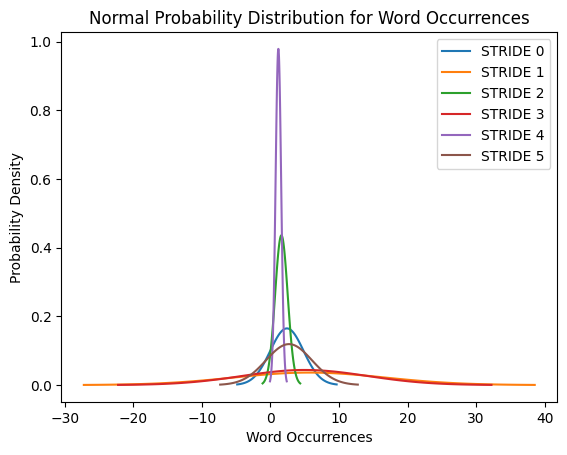

In [71]:
# def word_occurrence_by_group(df):
#     token_counts_by_group = {}
#     grouped_df = df.groupby('STRIDE')
#     for stride_value, group_df in grouped_df:
#         all_tokens = []
#         for tokens in group_df['NameDesc']:
#             all_tokens.extend(tokens)
#         token_count = Counter(all_tokens)
#         token_counts_by_group[stride_value] = token_count
#     return token_counts_by_group

# token_counts_by_group = word_occurrence_by_group(df_train)
# for stride_value, token_count in token_counts_by_group.items():
#     print(f"Word Occurrences for STRIDE '{stride_value}':")
#     print(token_count)
#     print()

def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')
    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)
        token_counts_by_group[stride_value] = token_count
    return token_counts_by_group

# prob distribution for word occurrence of entire corpus
def plot_normal_dist(token_counts_by_group):
    for stride_value, token_count in token_counts_by_group.items():
        mu = np.mean(list(token_count.values()))
        sigma = np.std(list(token_count.values()))
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=f'STRIDE {stride_value}')

    plt.title('Normal Probability Distribution for Word Occurrences')
    plt.xlabel('Word Occurrences')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

# Assuming df_train is your DataFrame
token_counts_by_group = word_occurrence_by_group(df_train)
plot_normal_dist(token_counts_by_group)

In [77]:
# words to keep
S_keep = ['information', 'detection', 'take',  'include', 'malicious', 'control', 'network', 'search', 'name', 'access', 'infrastructure', 'traffic', 'data', 'suspicious', 'trust', 'reconnaissance', 'email', 'phishing', 'resource', 'initial', 'visibility', 'monitor', 'server', 'form', 'open', 'potentially', 'websites', 'address', 'process', 'detect', 'credential', 'file', 'certificate', 'internet', 'install', 'key', 'online', 'link', 'source']
E_keep = ['process', 'access', 'file', 'execute', 'activity', 'execution', 'network', 'behavior', 'create', 'control', 'log', 'privilege', 'application', 'service', 'within', 'event', 'account', 'modify', 'run', 'abuse', 'monitoring', 'environment', 'binary', 'credential', 'enable', 'api', 'exe', 'function', 'payload', 'target', 'method', 'services', 'launch', 'root', 'os', 'many''accounts']
D_keep = ['service', 'target', 'tool', 'command', 'cause', 'server', 'network', 'outside', 'denial', 'dos', 'availability', 'high', 'destruction', 'infrastructure']
I_keep = ['data', 'network', 'activity', 'access', 'behavior', 'environment', 'process', 'detection', 'remote', 'base', 'target', 'tool', 'file', 'api', 'traffic', 'acquire', 'application', 'host', 'infrastructure', 'device']
R_keep = ['user', 'application', 'api', 'activity', 'audit', 'source', 'system', 'native', 'hide', 'error', 'intrusion', 'function', 'record', 'clear', 'gcp', 'permission', 'analysis', 'collection', 'updatesink', 'indicate', 'detection', 'data', 'collect', 'environment', 'call', 'limit', 'cloudtrail', 'loss', 'conduct', 'prior', 'delete', 'cloud', 'configservicev', 'cloudwatch', 'diagnostic', 'capability', 'sufficient', 'insight', 'avoid']
T_keep = ['malicious', 'file', 'activity', 'process', 'execute', 'access', 'information', 'control', 'software', 'modify', 'network', 'data', 'abuse', 'exe', 'manipulate', 'bypass', 'malware', 'functionality', 'integrity', 'dll', 'anomaly', 'install']

In [78]:
# combine both lists together by group
S_final = S + S_keep
T_final = T + T_keep
R_final = R + R_keep
I_final = I + I_keep
D_final = D + D_keep
E_final = E + E_keep

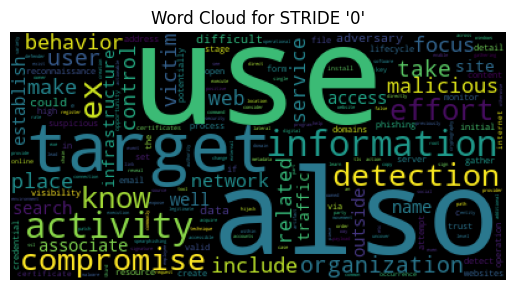

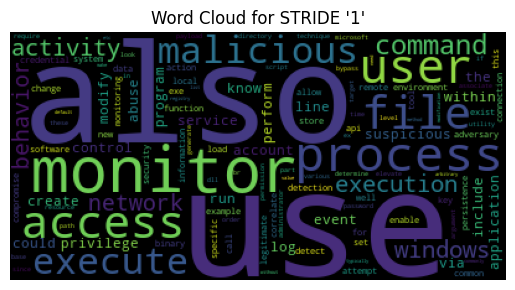

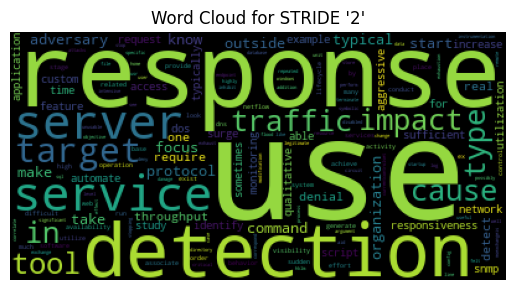

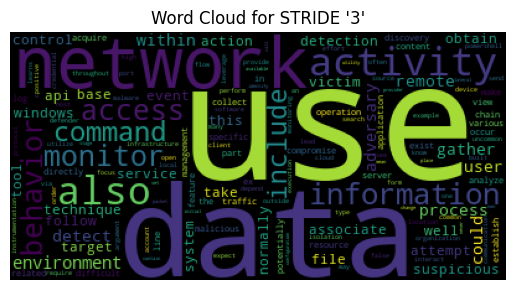

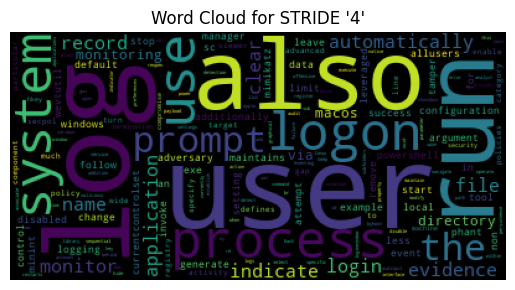

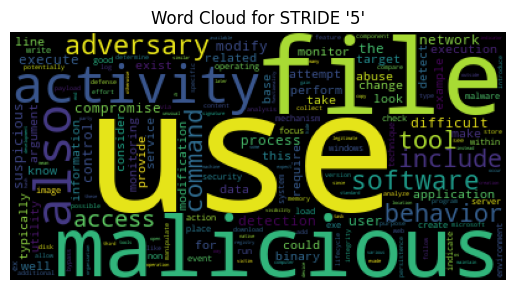

In [53]:
# Visualise word frequencies using word cloud
def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')
    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)
        token_counts_by_group[stride_value] = token_count
    return token_counts_by_group

token_counts_by_group = word_occurrence_by_group(df_train)
for stride_value, token_count in token_counts_by_group.items():
    wordcloud = WordCloud(background_color="black").generate_from_frequencies(token_count)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Word Cloud for STRIDE '{stride_value}'")
    plt.show()

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

df_train['NameDesc'] = df_train['NameDesc'].apply(lambda x: ' '.join(x))
df_test['NameDesc'] = df_test['NameDesc'].apply(lambda x: ' '.join(x))
df_dev['NameDesc'] = df_dev['NameDesc'].apply(lambda x: ' '.join(x))

X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['NameDesc']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(df_test['NameDesc']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(df_dev['NameDesc']).toarray()

y_train = df_train['STRIDE'].values
y_test = df_test['STRIDE'].values
y_val = df_dev['STRIDE'].values

In [ ]:
# hyperparameter tuning
# num_epochs = 50
# num_classes = 6
# vocab_size = X_train_tfidf.shape[1]
# dropout_rates = [0.2, 0.3, 0.4, 0.5]
# activations_list = ['relu', 'leaky_relu', 'elu', 'tanh']
# num_neurons = [32, 64, 128, 256]
# opt_lr = [1e-2, 1e-3, 1e-4]
# L2_lr = [1e-2, 1e-3, 1e-4]
# best_params = None
# best_val_acc = 0

# hyperparam_combi = itertools.product(dropout_rates, num_neurons, activations_list, opt_lr, L2_lr)

# for dr, nn, al, olr, l2lr in hyperparam_combi:
#     modelTest = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(vocab_size,)),
#     tf.keras.layers.Dense(nn*2, activation=al),
#     tf.keras.layers.Dropout(dr),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(nn, activation=al),
#     tf.keras.layers.Dropout(dr),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(nn//2, activation=al),
#     tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2), activation='softmax')
#     ])

#     optimizer = tf.keras.optimizers.legacy.Adam(olr)
#     modelTest.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
#     early_stop = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         verbose=0,
#         restore_best_weights=True
#     )
#     histTest = modelTest.fit(
#         X_train_tfidf, y_train,
#         batch_size=16,
#         epochs=num_epochs,
#         validation_data=(X_val_tfidf, y_val),
#         verbose=0,
#         callbacks=[early_stop,]
#     )

#     val_acc = max(histTest.history['val_accuracy'])
#     # print(f"Dropout: {dr}, Activation: {al}, Hidden Units: {nn}, L2 Reg: {l2lr}, LR: {olr}, Best Val Acc: {val_acc}\n===========================")
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_params = (dr, nn, al, olr, l2lr)
# print(f"Final Best Hyperparameters: Dropout: {best_params[0]},\nActivation: {best_params[2]},\nHidden Units: {best_params[1]},\nL2 Reg: {best_params[4]},\nLR: {best_params[3]},\nBest Val Acc: {best_val_acc}")

In [ ]:
# model
hidden_units = 32
batch_size = 16
num_epochs = 50
num_classes = 6
classes = [0,1,2,3,4,5]
vocab_size = X_train_tfidf.shape[1]
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(vocab_size,)),
    tf.keras.layers.Dense(hidden_units*2, activation='elu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(hidden_units, activation='elu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(hidden_units//2, activation='elu'),
    tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2), activation='softmax')
])

model4.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model4.summary()
# plot_model(model4, show_shapes=True, show_layer_names=True)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def plot_graph(hist, model, X_val_padded, y_val, classes):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')


    y_pred = np.argmax(model.predict(X_val_padded), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [ ]:
hist4 = model4.fit(
    X_train_tfidf, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_tfidf, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

In [ ]:
plot_graph(
    hist=hist4,
    model=model4,
    X_val_padded=X_test_tfidf,
    y_val=y_test,
    classes=classes
)